# Hazard assessment for river flooding using river discharge statistics: validation with observations

- A workflow from the CLIMAAX [Handbook](https://handbook.climaax.eu/) and [FLOODS](https://github.com/CLIMAAX/FLOODS) GitHub repository.
- See our [how to use risk workflows](https://handbook.climaax.eu/notebooks/workflows_how_to.html) page for information on how to run this notebook.

This workflow uses the dataset of hydrological climate impact indicators by SMHI that is [available via the Copernicus Data Store](https://doi.org/10.24381/cds.73237ad6).

To execute this notebook, the dataset of European river discharges will first be retrieved from the CLIMAAX data server, where a prepared copy is stored for easier and faster access. However, if you would like to download the data directly from CDS or if the dataset copy is not available, you can use the [previous notebook](./hazard_assessment_get_data.ipynb) to download the data.

This notebook is supplementary to the [main analysis notebook](./hazard_assessment_discharge_analysis.ipynb). It demonstrates how the modelled discharges dataset can be compared to local observations. This comparison is important to check how well the modelled data corresponds to the observations, in order to assess the accuracy of the modelled values for the specific location. Because the model dataset is based on a large-scale European hydrological model (E-HYPEcatch), the accuracy may vary depending on the geographical location and size of the river that is being considered.

To make the comparison to observations, we are using the daily discharge timeseries data from GRDC (Global Runoff Data Centre).

:::{note}
Alternative sources of observations can also be used, in this case it is necessary to adjust the part of the code where the observation data is being read into a `pandas.DataFrame`.
:::

## Preparation work

### Load libraries

`````{admonition} Find more info about the libraries used in this workflow here
:class: hint dropdown

In this notebook we will use the following Python libraries:

- [os](https://docs.python.org/3/library/os.html) - provides a way to interact with the operating system, allowing the creation of directories and file manipulation.
- [glob](https://docs.python.org/3/library/glob.html) - library for finding pathnames containing a specified patterns.
- [numpy](https://numpy.org/) - A powerful library for numerical computations in Python, widely used for array operations and mathematical functions.
- [xarray](https://docs.xarray.dev/en/stable/) - library for working with labelled multi-dimensional arrays.
- [geopandas](https://geopandas.org/en/stable/), [pyogrio](https://pyogrio.readthedocs.io/) - libraries for working with geospatial datasets.
- [shapely](https://github.com/shapely/shapely) - library for manipulation and analysis of geometric objects.
- [plotly](https://plotly.com/python/getting-started/) - interactive plotting library.
- [json](https://docs.python.org/3/library/json.html) - JSON encoder and decoder library.

These libraries collectively enable the download, processing, analysis, and visualization of geospatial and numerical data in this workflow.
`````

In [14]:
import os
from glob import glob

import pooch
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import pyogrio
from shapely.geometry import Point
import plotly.express as px
import plotly.graph_objects as go
import json

### Create the directory structure

We create the directory structure where the inputs and outputs of the workflow are stored.  
The next cell will create a directory called `FLOOD_RIVER_discharges` in the same directory where this notebook is saved.

If you have already ran the [notebook for downloading](./hazard_assessment_get_data.ipynb) the river discharges dataset directly from CDS, the workflow folder may already be present on your computer, and the pre-processed data is already found in the path defined under `data_folder`. Otherwise, the preprocessed data will be retrieved in this notebook from the CLIMAAX data server.

The data folder with observations data (in this example  - GRDC data) is specified as `data_folder_obs`.

In [15]:
# Define the folder for the flood workflow
workflow_folder = 'FLOOD_RIVER_discharges'
os.makedirs(workflow_folder, exist_ok=True)

# Directory for storing data
data_folder = os.path.join(workflow_folder, 'data')
os.makedirs(data_folder, exist_ok=True)

# Directory to store GRDC observation data
data_folder_obs = os.path.join(data_folder, 'GRDC')
os.makedirs(data_folder_obs, exist_ok=True)

# Define directory for plots
plot_dir = os.path.join(workflow_folder, 'plots_validation_GRDC')
os.makedirs(plot_dir, exist_ok=True)

### Accessing observation data from GRDC
To make the comparison to observations, we are using the daily discharge timeseries data from GRDC, that is freely available on the [GRDC data portal](https://portal.grdc.bafg.de/). In order to access the data you need to:
1. Go to [GRDC data portal](https://portal.grdc.bafg.de/) and accept the terms of use.
2. Select tab `Download by station`, and select `Table` view.
3. Find the station you are interested in using the filter search, and select the station by clicking on the tick-box. \
4. Press `Download` in the pop-up menu below and fill in the contact form. In the `Export format` field please select `GRDC Export Format (daily data only)`.
5. The link to download the data will be sent to your e-mail. After downloading the file, you need to unzip it and save the text file containing the discharge to a folder titled "GRDC" within the data folder (see below for the definition of the foolder to store this data, the folder path will be saved in the `data_folder_obs` variable). The name of the text file should already be in the following pattern: `{station number}_Q_Day.Cmd.txt`

After downloading the GRDC data for our location of interest, we need to specify the GRDC station number in the variable `grdc_nr` in order to locate the data more easily. The station number is the number at the start of the filename that was downloaded. The GRDC data files have a standardized format, so once we can locate the file we can obtain the station coordinates and name from the metadata header of this file later on in this notebook. 

In [12]:
grdc_nr = 6744201 # Alba Iulia, Romania

# Some examples of station numbers:
#grdc_nr = 6142200 # Bratislava, Slovakia
# grdc_nr = 6435060 # Lobith, The Netherlands
#grdc_nr = 6421102 # Venlo, the Netherlands - station with partial time coverage
# grdc_nr = 6340120 # Dresden, Germany

## Data selection

### Load GRDC observation data 
Define path to the data file based on the station name provided above:

In [16]:
filename = os.path.join(data_folder_obs, f'{grdc_nr}_Q_Day.Cmd.txt')

Read the station name and coordinates from the metadata, check if the station name and location are correct:

In [17]:
metadata = {}
with open(filename, 'r', encoding='cp1252') as f:
    for line in f:
        if line.startswith('#'):  # only look at metadata lines
            clean = line[1:].strip() # Remove "#" and strip spaces
            if ":" in clean:  # only lines with "key: value"
                key, value = clean.split(':', 1)
                metadata[key.strip()] = value.strip()
        else:
            break  # stop when actual data starts

locname = metadata.get('Station').replace(' ', '_')

lat = float(metadata.get('Latitude (DD)', 'nan'))
lon = float(metadata.get('Longitude (DD)', 'nan'))
loc = [lon, lat]

print(f'Station {locname}: {loc}')

Station ALBA_IULIA: [23.581667, 46.0375]


Read the timeseries data into a DataFrame:

In [18]:
df_obs = pd.read_csv(
    filename,
    comment='#',
    sep=';',
    skipinitialspace=True, 
    na_values=['--:--', -999.000],
    encoding='cp1252'
)
df_obs = df_obs.drop(columns='hh:mm').rename(columns={'YYYY-MM-DD': 'date'})
df_obs['date'] = pd.to_datetime(df_obs['date'], format='%Y-%m-%d')
df_obs.set_index('date', inplace=True)
df_obs.head()

,Value
date,
1951-01-01,41.7
1951-01-02,44.4
1951-01-03,42.6
1951-01-04,40.8
1951-01-05,39.0


Visualize the timeseries of the GRDC observations data:

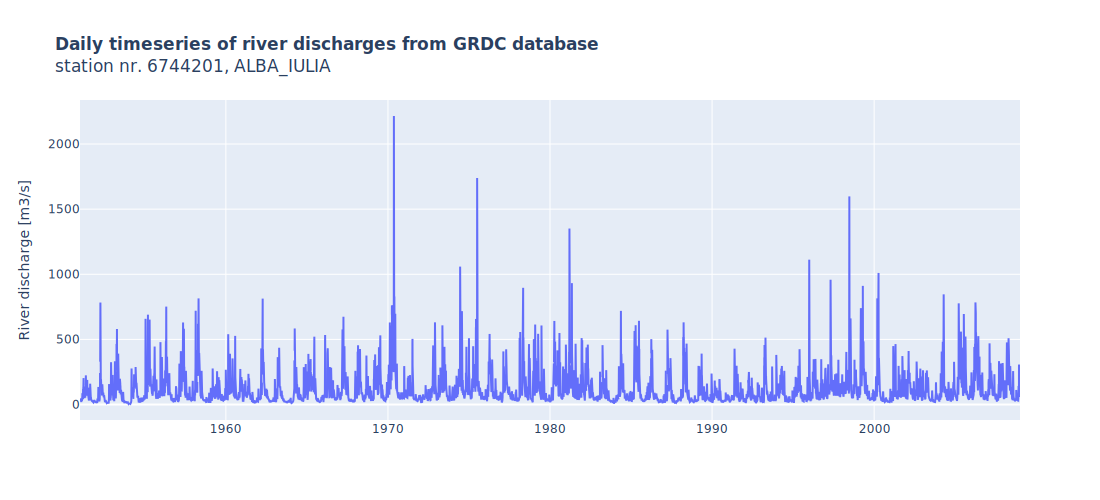

In [19]:
# Create a figure
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_obs.index, y=df_obs['Value'], mode='lines', name='observations'
))

# Customize layout
fig.update_layout(
    height=500, width=1100,
    title_text=(
        '<b>Daily timeseries of river discharges from GRDC database</b><br>'
        f'station nr. {grdc_nr}, {locname}'
    ),
    yaxis_title='River discharge [m3/s]',
    showlegend=False,
)

# Show the figure
fig.show()

# Save figure
fig.write_image(os.path.join(plot_dir, f'{locname}_timeseries_observed_GRDC.png'))

Based on the plot above we can check:
- which time period is the observation data available for?
- are there any gaps in the data?

To fully compare the model data to observations we preferably need observation data that covers 1991-2005 for comparing daily discharges, and 1971-2000 for comparing seasonal discharges. Does this dataset cover both of these periods? If it doesn't and there is significant amount of missing data in those time periods, it is recommended to use alternative sources of observation data or make the comparison for another station.

### Accessing model data
In this step we will check if the necessary model data is already available in the workflow folder or access it from the [CLIMAAX cloud storage](https://handbook.climaax.eu/resources/datasets/river_discharges_mirror.html).

In [20]:
def open_dataset(file, message='', folder=data_folder):
    local_path = os.path.join(folder, file)
    if os.path.exists(local_path):
        print(f'Dataset of {message} is already downloaded.')
        return xr.open_dataset(local_path)
    else:
        print(f'Accessing the dataset of {message} from CLIMAAX cloud storage.')
        file, _ = os.path.splitext(file)
        return xr.open_zarr(f'https://object-store.os-api.cci1.ecmwf.int/climaax/river_discharge_mirror/{file}.zarr')

We will open the datasets of daily and monthly values in order to use them in subsequent analysis. 

In [21]:
ds_day = open_dataset('rdis_day_E-HYPEcatch_allmodels.nc', message='daily river discharges')

Dataset of daily river discharges is already downloaded.


In [22]:
ds_mon = open_dataset('rdis_ymonmean_abs_E-HYPEcatch_allmodels.nc', message='monthly mean river discharges')

Dataset of monthly mean river discharges is already downloaded.


### Selecting the model catchment
The river discharges dataset contains discharges corresponding to a large number of small-scale catchments, identified using a catchment ID (coordinate `id` in the dataset). For further analysis, we need to be able to subset the dataset to a specific catchment in our area of interest. In order to know the ID of the catchment we are interested in, we need to consult the [map of catchments (sub-basins)](https://doi.org/10.5281/zenodo.581451).

In [23]:
data_folder_subbasins = os.path.join(data_folder, 'EHYPE3_subbasins')
os.makedirs(data_folder_subbasins, exist_ok=True)

Download the dataset of subbasins from Zenodo and unzip it in the folder specied as `data_folder_subbasins` located in the `data_folder` (created in the previous cell).
The next cell will retrieve the files automatically, but they can also be placed in the folder manually after downloading from the Zenodo web interface.

In [24]:
pooch.retrieve(
    'doi:10.5281/zenodo.581451/EHYPE3_subbasins.zip',
    known_hash='ce1a48393adba92443fb99cb2651b7cfadf60af9e4cce0ad9cae8e7b52d3c684',
    fname='EHYPE3_subbasins.zip',
    path=data_folder,
    downloader=pooch.DOIDownloader(),
    processor=pooch.Unzip(extract_dir=os.path.basename(data_folder_subbasins))
)

['C:\\git\\CLIMAAX\\FLOODS\\04_River_discharge_analysis\\FLOOD_RIVER_discharges\\data\\EHYPE3_subbasins\\EHYPE3_subbasins.dbf',
 'C:\\git\\CLIMAAX\\FLOODS\\04_River_discharge_analysis\\FLOOD_RIVER_discharges\\data\\EHYPE3_subbasins\\EHYPE3_subbasins.prj',
 'C:\\git\\CLIMAAX\\FLOODS\\04_River_discharge_analysis\\FLOOD_RIVER_discharges\\data\\EHYPE3_subbasins\\EHYPE3_subbasins.shp',
 'C:\\git\\CLIMAAX\\FLOODS\\04_River_discharge_analysis\\FLOOD_RIVER_discharges\\data\\EHYPE3_subbasins\\EHYPE3_subbasins.shx']

We can open the dataset of catchment contours as a GeoDataFrame variable:

In [25]:
try:
    catchments = gpd.GeoDataFrame.from_file(
        os.path.join(data_folder_subbasins, 'EHYPE3_subbasins.shp')
    )
    print('Dataset loaded.')
except pyogrio.errors.DataSourceError:
    print(f'Dataset with subbasin contours not found. Please download it and place it in the folder {data_folder_subbasins}')

catchments = catchments.set_index(catchments['SUBID'].astype(int))
catchments

Dataset loaded.


,SUBID,HAROID,geometry
SUBID,,,
8801544,8801544.0,8801544.0,"MULTIPOLYGON (((-22.9068 65.75671, -22.92437 6..."
8801548,8801548.0,8801548.0,"POLYGON ((-24.42223 65.55144, -24.39406 65.537..."
8000005,8000005.0,8000006.0,"MULTIPOLYGON (((9.3944 59.15315, 9.41203 59.14..."
8115258,8115258.0,8000006.0,"POLYGON ((8.5962 59.30061, 8.59918 59.29174, 8..."
8115717,8115717.0,8000006.0,"POLYGON ((9.27409 59.01988, 9.27962 59.00213, ..."
...,...,...,...
9566395,9566395.0,9566395.0,"POLYGON ((0.15417 49.37083, 0.15417 49.3625, 0..."
9581818,9581818.0,9581818.0,"MULTIPOLYGON (((-4.89583 55.7375, -4.87917 55...."
9524166,9524166.0,9524166.0,"MULTIPOLYGON (((-1.12917 45.34583, -1.12083 45..."


Now we need to identify the id of the catchment where the point of interest is located based on the coordinates stored in the variable `loc`. These are the coordinates of the GRDC station.

In [26]:
point = Point((loc[0], loc[1]))

in_catchment = catchments.geometry.contains(point)

catch_id = catchments[in_catchment].index.values[0]
print(f'Catchment ID in the E-HYPEcatch dataset: {catch_id}')

Catchment ID in the E-HYPEcatch dataset: 9605389


The catchment ID and contours will be stored in the variable `catchment`.

In [27]:
catchment = catchments.loc[[catch_id]]
catchment

,SUBID,HAROID,geometry
SUBID,,,
9605389,9605389.0,9600704.0,"POLYGON ((23.54584 46.07917, 23.54584 46.07084..."


Below the catchment contours will be plotted on a map to check whether correct catchment is selected. The coordinates of the observation location are indicated as a red dot, and contours of the corresponding catchment are displayed, as well as the surrounding catchments.

In [28]:
# Creating a marker for the selected catchment (used in the visualization on the map)
catchments['select'] = np.where(catchments.index==catch_id, 1, 0)

# Select only the nearby catchments within the radius of 1 degree
catchments_sel = catchments.cx[(loc[0]-1):(loc[0]+1), (loc[1]-1):(loc[1]+1)]

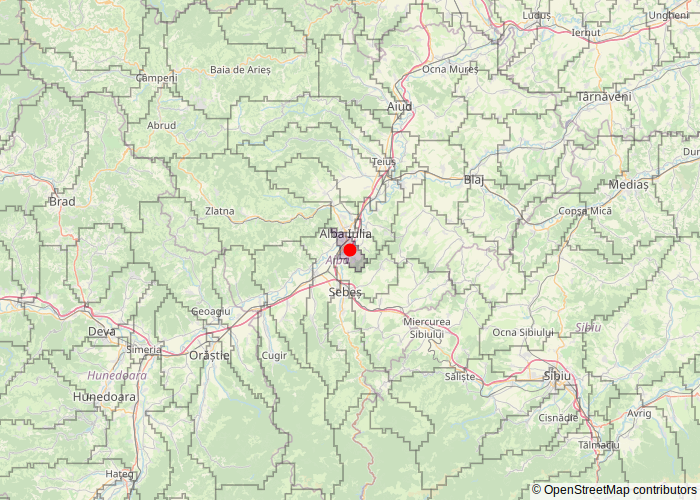

In [29]:
fig = go.Figure()

fig.add_trace(go.Scattermapbox(
    lat=[loc[1]],  # Latitude coordinates
    lon=[loc[0]],   # Longitude coordinates
    mode='markers',
    marker=go.scattermapbox.Marker(size=14, color='red'),
    text=['Location of interest'],  # Labels for the points
    name=''
))

fig.add_trace(go.Choroplethmapbox(
    geojson=json.loads(catchments_sel.to_json()),
    locations=catchments_sel.index,
    z=catchments_sel['select'],  
    hoverinfo='text',
    text=catchments_sel['SUBID'],  
    colorscale='RdPu',
    marker={'line': {'color': 'black', 'width': 1.5}},
    marker_opacity=0.2,  
    showscale=False
))

fig.update_layout(
    mapbox_center={'lat':loc[1], 'lon':loc[0]},
    mapbox_zoom=8,
    margin={'r': 0, 't': 0, 'l': 0, 'b': 0},
    mapbox={'style': 'open-street-map'})

fig.show()

fig.write_image(os.path.join(plot_dir, f'{locname}_location_catchment_map_GRDC_validation.png'))

## Comparing modelled and observed river discharges

We will create dataset variable `ds_day_sel` which will contain the daily timeseries of river discharges only for the selected catchment, taking mean values across the hydrological catchment models:

In [30]:
ds_day_sel = ds_day.sel(id=catch_id).mean(dim='catchmodel').compute(); del ds_day

In [31]:
ds_day_sel

<xarray.Dataset> Size: 176kB
Dimensions:  (gcm_rcm: 6, time: 5479)
Coordinates:
  * gcm_rcm  (gcm_rcm) <U33 792B 'ICHEC-EC-EARTH_CLMcom-CCLM4-8-17' ... 'MPI-...
  * time     (time) datetime64[ns] 44kB 1991-01-01 1991-01-02 ... 2005-12-31
    id       int32 4B 9605389
Data variables:
    rdis     (gcm_rcm, time) float32 131kB 27.48 26.04 24.72 ... 6.474 6.323

The plot below shows the modelled discharge timeseries based on different GCM-RCM climate model combinations as well as the values from the observational dataset from GRDC database. 
Please note that these climate models are not constrained by real-world observations, but are aiming instead to represent one possible realization of the climate in that period. Therefore, the modelled daily timeseries are not representative for comparing individual past weather events to observations - in the plot below we see different discharge patterns for the different GCM-RCM combinations.   

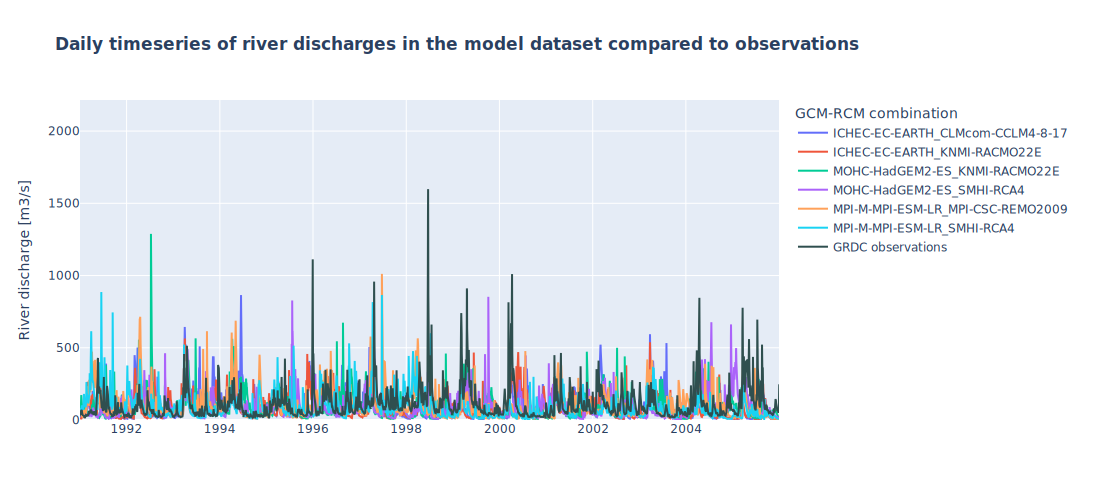

In [32]:
# Create a figure
fig = go.Figure()

for gcm_rcm in ds_day_sel.gcm_rcm.values:
    fig.add_trace(go.Scatter(x=ds_day_sel.time, y=ds_day_sel.rdis.sel(gcm_rcm=gcm_rcm), 
                             mode='lines', name=gcm_rcm))

fig.add_trace(go.Scatter(x=df_obs.index, y=df_obs['Value'], mode='lines', 
                        name='GRDC observations', line={'color': 'darkslategray', 'width': 2}))

fig.update_yaxes(range=[0, np.max([np.max(ds_day_sel.rdis.values), df_obs['Value'].max()])])

time_min = pd.Timestamp(ds_day_sel.time.min().values)
time_max = pd.Timestamp(ds_day_sel.time.max().values)
fig.update_xaxes(range=[time_min, time_max])

# Customize layout
fig.update_layout(
    height=500, width=1100, 
    title_text=('<b>Daily timeseries of river discharges in the model dataset compared to observations</b>'),
    yaxis_title='River discharge [m3/s]',
    showlegend=True,
    legend_title_text='GCM-RCM combination',
)

# Show the figure
fig.show()

# Save figure
fig.write_image(os.path.join(plot_dir, f'{locname}_daily_timeseries_with_GRDC_obs.png'))

### Flow-duration curve

Daily discharge statistics are a useful metric for understanding how representative the model results are compared to the local observations. Using the observation data, we can compare the exceedance curves of the daily discharges, also known as the flow-duration curve. The flow-duration curve provides an overview of the frequency of recurrence for different discharge values.
  
We can first compute the flow duration curve based on the modelled data below:

In [33]:
ds_flow_curve = xr.DataArray(
    data=-np.sort(-ds_day_sel.rdis.values, axis=1),
    dims=['gcm_rcm', 'exceedance'],
    coords={
        'gcm_rcm': ds_day_sel.gcm_rcm.values,
        'exceedance': np.arange(1.,len(ds_day_sel.time)+1) / len(ds_day_sel.time) * 100,
    }
)

We can also compute the flow-duration curve based on the observational data, after limiting the data to the same time period as the downloaded model data:

In [34]:
time_min = pd.Timestamp(ds_day_sel.time.min().values)
time_max = pd.Timestamp(ds_day_sel.time.max().values)
df_obs_clipped = df_obs.loc[time_min:time_max]
df_obs_clipped

,Value
date,
1991-01-01,39.6
1991-01-02,44.1
1991-01-03,47.3
1991-01-04,55.6
1991-01-05,58.3
...,...
2005-12-27,52.8
2005-12-28,57.9
2005-12-29,62.4


We can also calculate the time coverage, to check what fraction of the model time period the observations cover:

In [35]:
model_days = pd.date_range(ds_day_sel.time.min().item(), ds_day_sel.time.max().item(), freq='D')
obs_days = df_obs_clipped.index.normalize().unique()
coverage_fraction_day = len(np.intersect1d(model_days, obs_days)) / len(model_days) *100

print(f'Time coverage of observations relative to the model data is {coverage_fraction_day:.1f}%')

Time coverage of observations relative to the model data is 100.0%


Calculating the flow-duration curve:

In [36]:
ds_flow_curve_obs = xr.DataArray(
    data=-np.sort(-df_obs_clipped['Value'].values),
    dims=['exceedance'],
    coords={
        'exceedance': np.arange(1.,len(df_obs_clipped.index)+1) / len(df_obs_clipped.index) * 100
    }
)
ds_flow_curve_obs

<xarray.DataArray (exceedance: 5479)> Size: 44kB
array([1598., 1410., 1301., ...,   nan,   nan,   nan])
Coordinates:
  * exceedance  (exceedance) float64 44kB 0.01825 0.0365 0.05475 ... 99.98 100.0

The resulting flow-duration curve is plotted below. The plot is interactive and makes it possible to zoom in and inspect the data, as well as to (de)select GCM-RCM model combinations in the legend.  

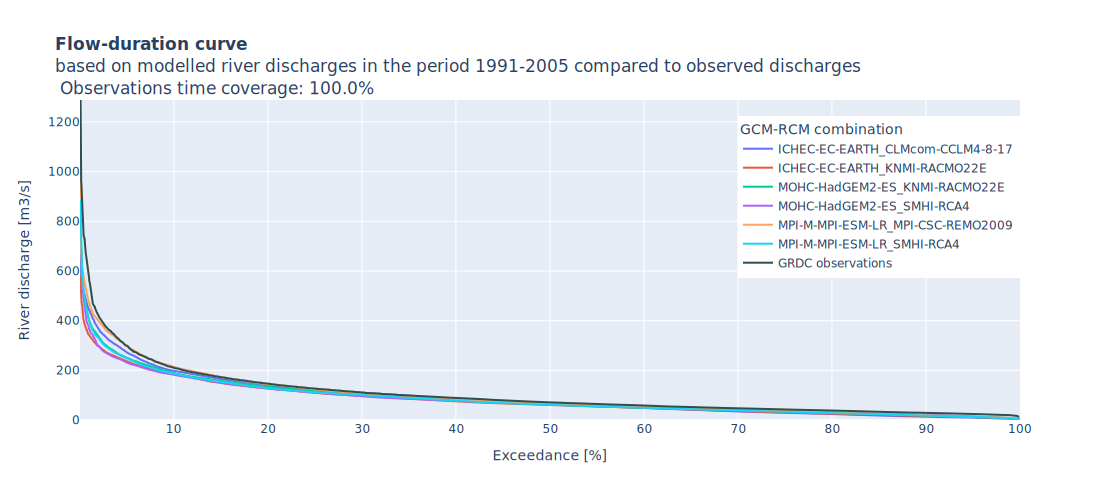

In [37]:
# Create a figure
fig = go.Figure()

for gcm_rcm in ds_day_sel.gcm_rcm.values:
    fig.add_trace(go.Scatter(x=ds_flow_curve.exceedance, y=ds_flow_curve.sel(gcm_rcm=gcm_rcm),
                             mode='lines', name=gcm_rcm))

fig.add_trace(go.Scatter(x=ds_flow_curve_obs.exceedance, y=ds_flow_curve_obs, mode='lines', 
                            name=f'GRDC observations', line={'color': 'darkslategray', 'width': 2}))

fig.update_yaxes(range=[0, np.max(ds_flow_curve.values)])

# Customize layout
str_daily_timerange = f'{ds_day_sel.time.dt.year.values[0]}-{ds_day_sel.time.dt.year.values[-1]}'

fig.update_layout(
    height=500,
    width=1100,
    title_text=(
        '<b>Flow-duration curve</b>'
        f'<br>based on modelled river discharges in the period {str_daily_timerange} compared to observed discharges'
        f'<br> Observations time coverage: {coverage_fraction_day:.1f}%'
    ),
    yaxis_title='River discharge [m3/s]',
    xaxis_title='Exceedance [%]',
    showlegend=True,
    legend_title_text='GCM-RCM combination',
    legend={'x': 0.7, 'y': 0.95},
)

# Show the figure
fig.show()

# Save figure
fig.write_image(os.path.join(plot_dir, f'{locname}_flow-duration_curve_compared_to_GRDC_observations.png'))

### Comparing seasonal variations of river discharges between the models and observations

We can check how the seasonal variation of the modelled historical river discharges compares to the observation data.

We start by selecting the data for the specific catchment from the model dataset of monthly mean river discharges. We will directly take a mean across catchment models to simplify the futher assessment.

In [38]:
ds_mon_sel = ds_mon.sel(id=catch_id).mean(dim='catchmodel'); del ds_mon
ds_mon_sel

<xarray.Dataset> Size: 5kB
Dimensions:        (time_period: 4, scenario: 3, gcm_rcm: 6, time: 12)
Coordinates:
  * time_period    (time_period) <U9 144B '1971-2000' ... '2071-2100'
  * gcm_rcm        (gcm_rcm) <U36 864B 'ICHEC-EC-EARTH_CLMcom-CCLM4-8-17-v1' ...
  * time           (time) float64 96B 1.0 2.0 3.0 4.0 5.0 ... 9.0 10.0 11.0 12.0
    id             int32 4B 9605389
  * scenario       (scenario) <U10 120B 'historical' 'rcp45' 'rcp85'
Data variables:
    rdis_ymonmean  (time_period, scenario, gcm_rcm, time) float32 3kB 45.13 ....

We also need to calculate monthly means from the GRDC observations data, after limiting the dataset to the same time period as the 'historical' time period in the model data:

In [39]:
time_hist_min = pd.Timestamp(year=1971, month=1, day=1)
time_hist_max = pd.Timestamp(year=2000, month=12, day=31)
df_obs_hist = df_obs.loc[time_hist_min:time_hist_max]
monthly_mean_obs = df_obs_hist.groupby(df_obs_hist.index.month).mean()

We can check the time coverage of the observations in the historical time period 1971-2000:

In [40]:
model_hist = pd.date_range(time_hist_min, time_hist_max, freq='D')
obs_hist = df_obs_hist.index.normalize().unique()
coverage_fraction_hist = len(np.intersect1d(model_hist, obs_hist)) / len(model_hist) * 100

print(f'Time coverage of observations relative to the model data is {coverage_fraction_hist:.1f}%')

Time coverage of observations relative to the model data is 100.0%


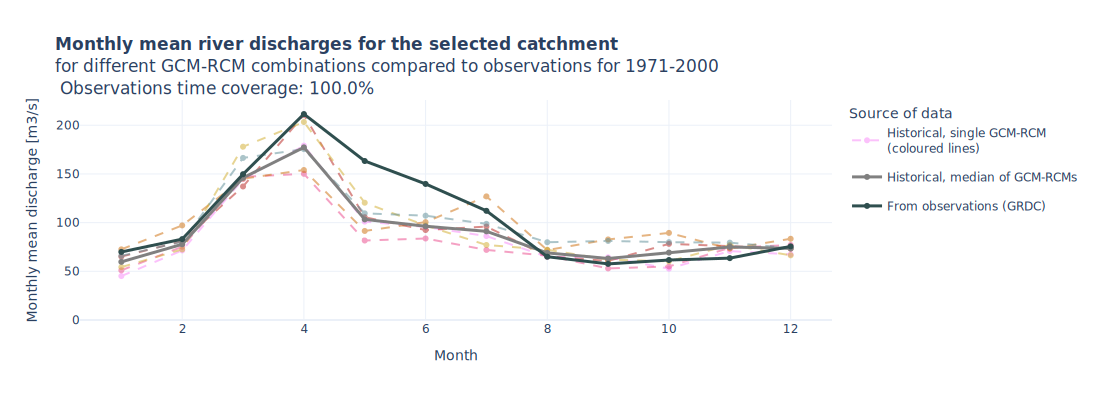

In [41]:
# Create a figure
fig = go.Figure()

colorlist = px.colors.cyclical.mrybm[::2]
dashlist = ['dot', 'dash']

for ii, gcm_rcm in enumerate(ds_mon_sel.gcm_rcm.values):
    fig.add_trace(go.Scatter(x=ds_mon_sel.time, y=ds_mon_sel.rdis_ymonmean.sel(gcm_rcm=gcm_rcm).sel(time_period='1971-2000', scenario='historical'), 
                             mode='lines+markers', line={'color': colorlist[ii], 'dash': 'dash'}, opacity=0.5, 
                             name=f'Historical, single GCM-RCM<br>(coloured lines)', legendgroup=f'Historical, single GCM-RCM', 
                             text = f'{gcm_rcm}', showlegend=(ii==0)))
    
fig.add_trace(go.Scatter(x=ds_mon_sel.time, y=ds_mon_sel.rdis_ymonmean.sel(time_period='1971-2000', scenario='historical').median(dim='gcm_rcm'), 
                            mode='lines+markers', line={'color': 'gray', 'width': 3}, name=f'Historical, median of GCM-RCMs', 
                            text = f'Historical (1971-2000), GCM-RCM median'))

fig.add_trace(go.Scatter(x=monthly_mean_obs.index, y=monthly_mean_obs['Value'], 
                            mode='lines+markers', line={'color': 'darkslategray', 'width': 3}, name=f'From observations (GRDC)', 
                            text = f'Observations GRDC'))

fig.update_yaxes(range=[0, np.nanmax(ds_mon_sel.rdis_ymonmean.values)*1.05])

# Customize layout
fig.update_layout(
    height=400,
    width=1100, 
    title_text=(
        '<b>Monthly mean river discharges for the selected catchment</b>'
        '<br>for different GCM-RCM combinations compared to observations for 1971-2000'
        f'<br> Observations time coverage: {coverage_fraction_hist:.1f}%'
    ),
    yaxis_title='Monthly mean discharge [m3/s]',
    xaxis_title='Month',
    showlegend=True,
    template='plotly_white',
    legend_title_text='Source of data',
)

# Show the figure
fig.show()

# Save figure
fig.write_image(os.path.join(plot_dir, f'{locname}_monthly_mean_compared_to_observations.png'))

## Contributors

Author of the workflow: Natalia Aleksandrova (Deltares)